In [1]:
import librosa

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
import torchaudio
from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 36.4MB/s]


In [3]:
wav, sr = librosa.load(SAMPLE_WAV, sr = 16000)
print(wav.shape)
print(sr)

(54400,)
16000


In [4]:
def _hann_window(frame_length):
    return (0.5 - 0.5*np.cos(2*np.pi*np.arange(0, 1.0, 1.0/frame_length))).astype(np.float32)
han_window = _hann_window(480)
han_window.shape

(480,)

In [92]:
def convert2mel(freq):
    return 1125*np.log(1 + freq/700)

In [98]:
def convert2freq(mel):
    return 700*(np.exp(mel/1125)-1)

In [101]:
np.log(2)

0.6931471805599453

In [106]:
def melscale(bins, freq):
    res = []
    len_bin = len(bins)
    for m in range(1, len_bin-1):
        bin_val = 0
        for i in range(int(bins[m-1]), int(bins[m+1])):
            if i < m:
                scale = (i - bins[m-1])/(bins[m] - bins[m-1])
            elif i > m:
                scale = (bins[m+1] - i)/(bins[m+1] - bins[m])
            else:
                scale = 1
            bin_val += scale*freq[i]
        res.append(bin_val)
    return res

In [128]:
def kiss_mel_spectrogram(waveform,
                         sample_rate,
                         n_mels,
                         n_fft,
                         win_length,
                         hop_length,
                         f_min = 0,
                         f_max = None,
                         power = 2):
    fft_stack = []
    len_wav = len(waveform)
    hann_win = _hann_window(win_length)
    min_mels = convert2mel(f_min)
    max_mels = convert2mel(f_max if f_max else sample_rate//2)
    m = np.linspace(min_mels, max_mels, n_mels + 2)
    h = convert2freq(m)
    f = np.floor((n_fft+1)*h/sample_rate)
    for i in range(len_wav//hop_length):
        swav = waveform[hop_length*i: min(hop_length*i+win_length, len_wav)]
        len_swav = len(swav)
        if len_swav < win_length:
           pad = np.zeros(win_length - len_swav)
           swav = np.concatenate((swav, pad))
        swav = swav*hann_win
        spow = np.abs(np.fft.fft(swav, n = n_fft)[:n_fft//2+1])**power
        smel = np.array(melscale(f, spow))
        fft_stack.append(smel)
    mel_spec = np.stack(fft_stack, axis = 0)
    #spec = np.abs(spec)**power
    return mel_spec

In [129]:
spec = kiss_mel_spectrogram(wav,
                            16000,
                            40,
                            512,
                            480,
                            160,
                            power = 2)
spec.shape

(340, 40)

In [130]:
np.log(spec+1e-6).max()

8.228720136997852

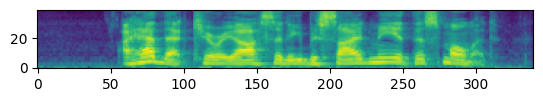

In [136]:
plt.imshow(np.log(spec + 1e-6).T, origin = 'lower')

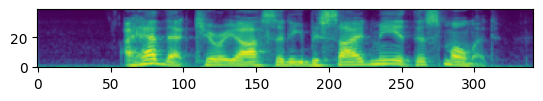

In [137]:
l_mel = librosa.feature.melspectrogram(y = wav, sr = 16000, n_fft = 512, win_length = 480, hop_length = 160, n_mels = 40)
plt.imshow(np.log(l_mel + 1e-6), origin = 'lower')

In [122]:
np.log(l_mel+1e-6).max()

3.3030255

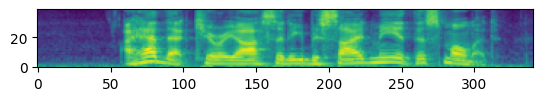

In [138]:
import torch

torch_wav, sr = torchaudio.load(SAMPLE_WAV)
torch_spec = torchaudio.transforms.MelSpectrogram(n_fft = 512,
                                                  sample_rate = 16000,
                                                  n_mels = 40,
                                               win_length = 480,
                                               hop_length = 160,
                                               power = 2)(torch_wav)
plt.imshow(torch.log(torch_spec + 1e-6).squeeze(), origin = 'lower')

In [119]:
torch_spec.max()

tensor(1813.5691)

In [160]:
def onl_mel_spectrogram(waveform,
                    buffer_size,
                    sample_rate,
                    n_mels,
                    n_fft,
                    win_length,
                    hop_length,
                    f_min = 0,
                    f_max = None,
                    power = 2):
    spec_stack = []
    len_wav = len(waveform)
    for i in range(len_wav//buffer_size+1):
        swav = waveform[(i*buffer_size): min((i+1)*buffer_size, len_wav)]
        try:
            sspec = kiss_mel_spectrogram(swav, 16000, n_mels, n_fft, win_length, hop_length, f_min, f_max, power)
        except ValueError:
            continue
        spec_stack.append(sspec)
    spec = np.concatenate(spec_stack, axis = 0)
    return spec

In [161]:
onl_spec = onl_mel_spectrogram(wav, 480, 16000, 40, 512, 480, 160, 2)
onl_spec.shape

(340, 40)

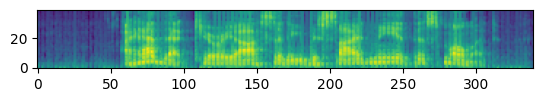

In [162]:
plt.imshow(np.log(onl_spec + 1e-6).T, origin = 'lower')

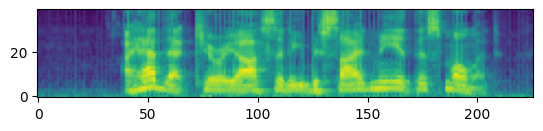

In [159]:
plt.imshow(np.log(onl_spec + 1e-6).T, origin = 'lower')